In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 2.)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [3]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/abcd/")
hcp_data_dict = np.load(data_dir/"abcd_data_dict.npy", allow_pickle=True).item()
brain_networks = hcp_data_dict["network"] / count_offset
traits = hcp_data_dict["cog"][:,4] 
avg_trans = np.nanmean(hcp_data_dict["trans"], -1)
avg_rotat = np.nanmean(hcp_data_dict["rotat"], -1)

nan_mask = np.argwhere(~np.isnan(traits))
brain_networks = brain_networks[nan_mask]
traits = traits[nan_mask]
avg_trans = avg_trans[nan_mask]
avg_rotat = avg_rotat[nan_mask]
n_subs = brain_networks.shape[0]

print(brain_networks.shape)
print(traits.shape)
print(avg_trans.shape)

(5130, 1, 68, 68)
(5130, 1)
(5130, 1)


In [4]:
motion = np.concatenate([avg_trans, avg_rotat], axis=-1)

In [5]:
sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_trans_ids = sub_ids[avg_trans > np.quantile(avg_trans, .98)]
big_rotat_ids = sub_ids[avg_rotat > np.quantile(avg_rotat, .98)]
small_trans_ids = sub_ids[avg_trans < np.quantile(avg_trans, .02)]
small_rotat_ids = sub_ids[avg_rotat < np.quantile(avg_rotat, .02)]

In [6]:
big_trans = avg_trans[big_trans_ids].reshape(-1,1)
small_trans = avg_trans[small_trans_ids].reshape(-1,1)
big_rotat = avg_rotat[big_rotat_ids].reshape(-1,1)
small_rotat = avg_rotat[small_rotat_ids].reshape(-1,1)

In [7]:
big_trans_nets = brain_networks[big_trans_ids].reshape(-1,n_rois*n_rois)
small_trans_nets = brain_networks[small_trans_ids].reshape(-1,n_rois*n_rois)
diff_trans_nets = big_trans_nets.mean(0) - small_trans_nets.mean(0)

big_rotat_nets = brain_networks[big_rotat_ids].reshape(-1,n_rois*n_rois)
small_rotat_nets = brain_networks[small_rotat_ids].reshape(-1,n_rois*n_rois)
diff_rotat_nets = big_rotat_nets.mean(0) - small_rotat_nets.mean(0)

In [8]:
pca = PCA(2)
obs_trans_Xt = pca.fit_transform(np.vstack([big_trans_nets, small_trans_nets]))
obs_trans_df = pd.DataFrame({"pc1": obs_trans_Xt[:,0], 
                       "pc2": obs_trans_Xt[:,1], 
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
obs_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_nets, small_rotat_nets]))
obs_rotat_df = pd.DataFrame({"pc1": obs_rotat_Xt[:,0], 
                       "pc2": obs_rotat_Xt[:,1], 
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

In [9]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.1,
    beta = .01, add_reg = True, y_dim = 1, 
    batch_size=64, n_epochs=250, lr=5e-6, device=DEVICE)

In [10]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [11]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

4617 513


vae

In [12]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [13]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 10091.093 nll: 1727.594 kl: 77.274 rmse: 11.460
epoch: 0 test loss: 6557.740 nll: -1019.561 kl: 181.010 rmse: 10.997
epoch: 5 train loss: -2184.923 nll: -2785.493 kl: 9872.070 rmse: 2.791
epoch: 5 test loss: -2214.780 nll: -2781.926 kl: 10824.379 rmse: 2.697
epoch: 10 train loss: -2374.637 nll: -2844.113 kl: 12205.594 rmse: 2.326
epoch: 10 test loss: -2315.676 nll: -2830.556 kl: 12077.580 rmse: 2.515
epoch: 15 train loss: -2401.166 nll: -2858.275 kl: 11908.841 rmse: 2.295
epoch: 15 test loss: -2336.767 nll: -2843.281 kl: 11803.233 rmse: 2.496
epoch: 20 train loss: -2416.850 nll: -2863.901 kl: 11659.847 rmse: 2.270
epoch: 20 test loss: -2351.372 nll: -2848.683 kl: 11570.446 rmse: 2.474
epoch: 25 train loss: -2430.470 nll: -2866.883 kl: 11452.055 rmse: 2.240
epoch: 25 test loss: -2364.026 nll: -2851.598 kl: 11352.129 rmse: 2.449
epoch: 30 train loss: -2442.760 nll: -2868.784 kl: 11259.271 rmse: 2.211
epoch: 30 test loss: -2376.149 nll: -2853.669 kl: 11152.659 rmse: 2

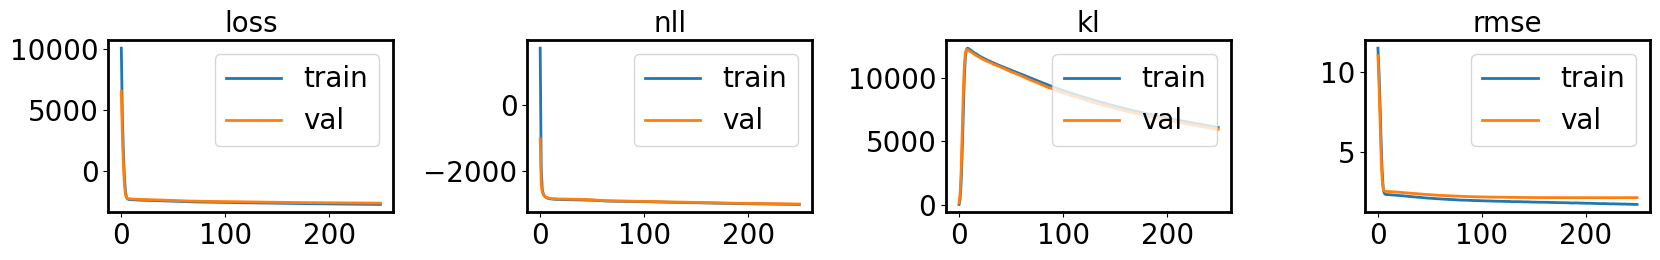

In [14]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [15]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_recon = x_recon*count_offset

In [16]:
big_trans_recon = x_recon[big_trans_ids]
small_trans_recon = x_recon[small_trans_ids]
diff_trans_recon = big_trans_recon.mean(0) - small_trans_recon.mean(0)

big_rotat_recon = x_recon[big_rotat_ids]
small_rotat_recon = x_recon[small_rotat_ids]
diff_rotat_recon = big_rotat_recon.mean(0) - small_rotat_recon.mean(0)

In [17]:
big_trans_latents = vae_latents[big_trans_ids]
small_trans_latents = vae_latents[small_trans_ids]
big_rotat_latents = vae_latents[big_rotat_ids]
small_rotat_latents = vae_latents[small_rotat_ids]

In [18]:
pca = PCA(2)
vae_trans_Xt = pca.fit_transform(np.vstack([big_trans_latents, small_trans_latents]))
vae_trans_df = pd.DataFrame({"pc1": vae_trans_Xt[:,0], 
                       "pc2": vae_trans_Xt[:,1], 
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
vae_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_latents, small_rotat_latents]))
vae_rotat_df = pd.DataFrame({"pc1": vae_rotat_Xt[:,0], 
                       "pc2": vae_rotat_Xt[:,1], 
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

inv-vae

In [19]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.1, 
    beta = 100., gamma = .1, add_reg = True, y_dim = 1,
    batch_size=64, n_epochs=250, lr=5e-6, device=DEVICE)

In [20]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [21]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 8799.089 nll: 1786.979 kl: 72.630 inv_loss: 0.284 rmse: 11.618
epoch: 0 test loss 7833.361 nll: -901.454 kl: 160.874 inv_loss: 0.182 rmse: 11.234
epoch: 5 train loss: 819.698 nll: -2777.571 kl: 11628.419 inv_loss: 2.224 rmse: 3.683
epoch: 5 test loss 474.666 nll: -2775.410 kl: 11206.124 inv_loss: 0.463 rmse: 3.317
epoch: 10 train loss: 329.559 nll: -2839.326 kl: 16814.497 inv_loss: 2.641 rmse: 2.334
epoch: 10 test loss 166.140 nll: -2826.236 kl: 14556.330 inv_loss: 0.466 rmse: 2.538
epoch: 15 train loss: 253.313 nll: -2854.407 kl: 16572.890 inv_loss: 2.013 rmse: 2.294
epoch: 15 test loss 146.740 nll: -2839.401 kl: 14739.555 inv_loss: 0.408 rmse: 2.500
epoch: 20 train loss: 204.473 nll: -2860.320 kl: 16657.073 inv_loss: 1.618 rmse: 2.265
epoch: 20 test loss 130.577 nll: -2844.925 kl: 15023.244 inv_loss: 0.357 rmse: 2.466
epoch: 25 train loss: 165.420 nll: -2863.283 kl: 16664.209 inv_loss: 1.330 rmse: 2.230
epoch: 25 test loss 116.433 nll: -2847.720 kl: 15129.171 inv

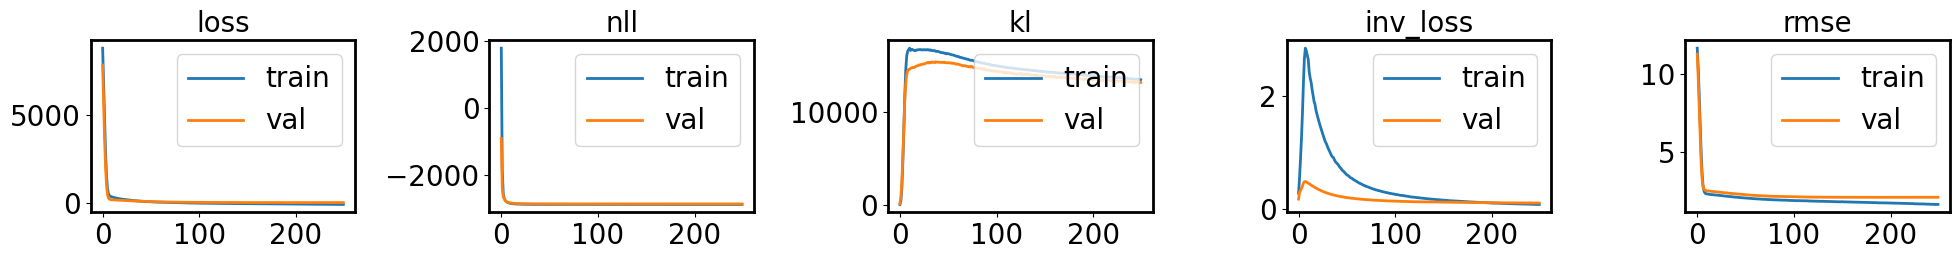

In [22]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [23]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()

x_denoised = inv_model.decode(z_sample, 
                      torch.zeros_like(tensor_motion).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_denoised = x_denoised*count_offset

In [24]:
big_trans_denoised = x_denoised[big_trans_ids]
small_trans_denoised = x_denoised[small_trans_ids]
diff_trans_denoised = big_trans_denoised.mean(0) - small_trans_denoised.mean(0)

big_rotat_denoised = x_denoised[big_rotat_ids]
small_rotat_denoised = x_denoised[small_rotat_ids]
diff_rotat_denoised = big_rotat_denoised.mean(0) - small_rotat_denoised.mean(0)

In [25]:
big_trans_inv_latents = inv_latents[big_trans_ids]
small_trans_inv_latents = inv_latents[small_trans_ids]
big_rotat_inv_latents = inv_latents[big_rotat_ids]
small_rotat_inv_latents = inv_latents[small_rotat_ids]

In [26]:
pca = PCA(2)
inv_vae_trans_Xt = pca.fit_transform(np.vstack([big_trans_inv_latents, small_trans_inv_latents]))
inv_vae_trans_df = pd.DataFrame({"pc1": inv_vae_trans_Xt[:,0], 
                       "pc2": inv_vae_trans_Xt[:,1], 
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
inv_vae_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_inv_latents, small_rotat_inv_latents]))
inv_vae_rotat_df = pd.DataFrame({"pc1": inv_vae_rotat_Xt[:,0], 
                       "pc2": inv_vae_rotat_Xt[:,1], 
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

plotting

In [43]:
n=39
x = 0.32 # 0.32
cmap = plt.cm.coolwarm
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('div_cmap', colors)

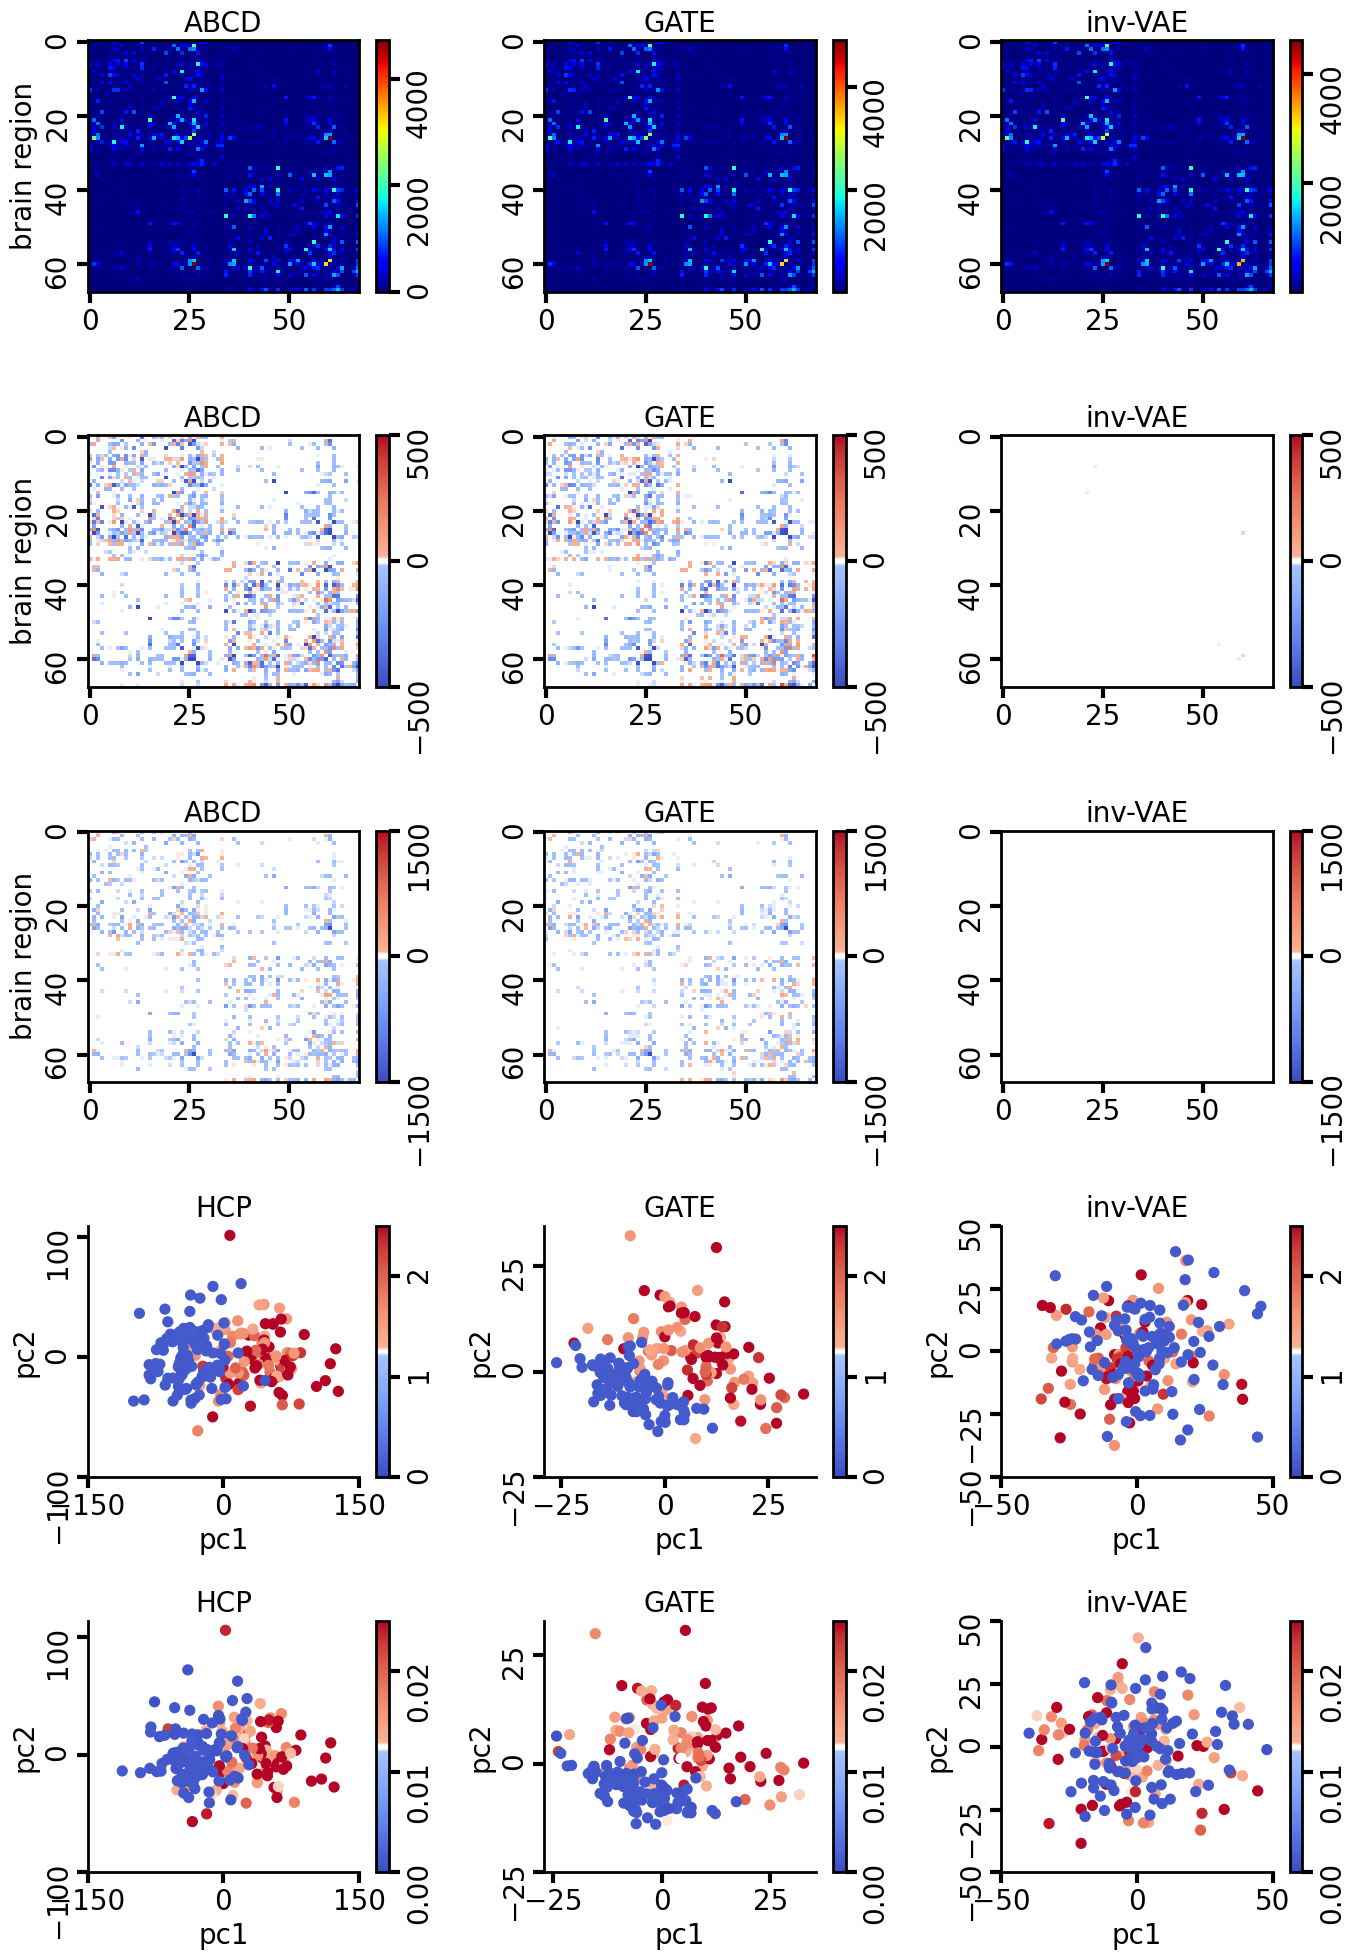

In [47]:
fig, axes = plt.subplots(5, 3, figsize=(14, 20))

p1 = axes[0,0].imshow(brain_networks.mean(0).reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap='jet')
axes[0,0].set_title('ABCD')
axes[0,0].set_ylabel('brain region')
axes[0,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,0].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p1, ax=axes[0,0])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 4000, 8000])

p2 = axes[1,0].imshow(diff_trans_nets.reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap=div_cmap, vmin=-500, vmax=500)
axes[1,0].set_title('ABCD')
axes[1,0].set_ylabel('brain region')
axes[1,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[1,0].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p2, ax=axes[1,0])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-500, 0, 500])


p3 = axes[2,0].imshow(diff_rotat_nets.reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap=div_cmap, vmin=-1500, vmax=1500)
axes[2,0].set_title('ABCD')
axes[2,0].set_ylabel('brain region')
axes[2,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[2,0].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p3, ax=axes[2,0])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-1500, 0, 1500])

p4 = axes[3,0].scatter(x="pc1", y="pc2", c="trans", cmap=div_cmap, 
                       data=obs_trans_df, s=50, alpha=1., vmin=0, vmax=2.5)
axes[3,0].set_xlabel('pc1')
axes[3,0].set_ylabel('pc2')
axes[3,0].spines['top'].set_visible(False)
axes[3,0].spines['right'].set_visible(False)
axes[3,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[3,0].tick_params(axis='x', length=8, width=3)
axes[3,0].set_title('HCP')
cbar = plt.colorbar(p4, ax=axes[3,0])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 0.25, .5])
axes[3,0].set_yticks([-100, 0, 100])
axes[3,0].set_xticks([-150, 0, 150])

p5 = axes[4,0].scatter(x="pc1", y="pc2", c="rotat", cmap=div_cmap, 
                       data=obs_rotat_df, s=50, alpha=1., vmin=0, vmax=0.025)
axes[4,0].set_xlabel('pc1')
axes[4,0].set_ylabel('pc2')
axes[4,0].set_title('HCP')
axes[4,0].spines['top'].set_visible(False)
axes[4,0].spines['right'].set_visible(False)
axes[4,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[4,0].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p5, ax=axes[4,0])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 0.0025, .005])
# cbar.set_ticklabels([0, 2.5, 5])
axes[4,0].set_yticks([-100, 0, 100])
axes[4,0].set_xticks([-150, 0, 150])

p6 = axes[0,1].imshow(x_recon.mean(0), aspect='auto', cmap='jet')
axes[0,1].set_title('GATE')
axes[0,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,1].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p6, ax=axes[0,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 4000, 8000])

p7 = axes[1,1].imshow(diff_trans_recon, aspect='auto', cmap=div_cmap, vmin=-500, vmax=500)
axes[1,1].set_title('GATE')
axes[1,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[1,1].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p7, ax=axes[1,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-500, 0, 500])

p8 = axes[2,1].imshow(diff_rotat_recon.reshape(n_rois,n_rois), 
                      aspect='auto', cmap=div_cmap, vmin=-1500, vmax=1500)
axes[2,1].set_title('GATE')
axes[2,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[2,1].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p8, ax=axes[2,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-1500, 0, 1500])

p9 = axes[3,1].scatter(x="pc1", y="pc2", c="trans", cmap=div_cmap, 
                       data=vae_trans_df, s=50, alpha=1., vmin=0, vmax=2.5)
axes[3,1].set_xlabel('pc1')
axes[3,1].set_ylabel('pc2')
axes[3,1].set_title('GATE')
axes[3,1].spines['top'].set_visible(False)
axes[3,1].spines['right'].set_visible(False)
axes[3,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[3,1].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p9, ax=axes[3,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 0.25, .5])
axes[3,1].set_yticks([-25, 0, 25])
axes[3,1].set_xticks([-25, 0, 25])

p10 = axes[4,1].scatter(x="pc1", y="pc2", c="rotat", cmap=div_cmap, 
                        data=vae_rotat_df, s=50, alpha=1., vmin=0, vmax=0.025)
axes[4,1].set_xlabel('pc1')
axes[4,1].set_ylabel('pc2')
axes[4,1].set_title('GATE')
axes[4,1].spines['top'].set_visible(False)
axes[4,1].spines['right'].set_visible(False)
axes[4,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[4,1].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p10, ax=axes[4,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 0.0025, .005])
# cbar.set_ticklabels([0, 2.5, 5])
axes[4,1].set_yticks([-25, 0, 25])
axes[4,1].set_xticks([-25, 0, 25])

p11 = axes[0,2].imshow(x_denoised.mean(0), aspect='auto', cmap='jet')
axes[0,2].set_title('inv-VAE')
axes[0,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,2].tick_params(axis='x', length=8, width=3)
axes[0,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,2].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p11, ax=axes[0,2])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 4000, 8000])

p12 = axes[1,2].imshow(diff_trans_denoised, aspect='auto', cmap=div_cmap, vmin=-500, vmax=500)
axes[1,2].set_title('inv-VAE')
axes[1,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[1,2].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p12, ax=axes[1,2])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-500, 0, 500])

p13 = axes[2,2].imshow(diff_rotat_denoised.reshape(n_rois,n_rois), 
                      aspect='auto', cmap=div_cmap, vmin=-1500, vmax=1500)
axes[2,2].set_title('inv-VAE')
axes[2,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[2,2].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p13, ax=axes[2,2])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-1500, 0, 1500])

p14 = axes[3,2].scatter(x="pc1", y="pc2", c="trans", cmap=div_cmap, 
                        data=inv_vae_trans_df, s=50, alpha=1., vmin=0, vmax=2.5)
axes[3,2].set_xlabel('pc1')
axes[3,2].set_ylabel('pc2')
axes[3,2].set_title('inv-VAE')
axes[3,2].spines['top'].set_visible(False)
axes[3,2].spines['right'].set_visible(False)
axes[3,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[3,2].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p14, ax=axes[3,2])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 0.25, .5])
axes[3,2].set_ylim(-50, 50)
axes[3,2].set_xlim(-50, 50)

p15 = axes[4,2].scatter(x="pc1", y="pc2", c="rotat", cmap=div_cmap, 
                        data=inv_vae_rotat_df, s=50, alpha=1., vmin=0, vmax=0.025)
axes[4,2].set_xlabel('pc1')
axes[4,2].set_ylabel('pc2')
axes[4,2].set_title('inv-VAE')
axes[4,2].spines['top'].set_visible(False)
axes[4,2].spines['right'].set_visible(False)
axes[4,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[4,2].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p15, ax=axes[4,2])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([0, 0.0025, .005])
# cbar.set_ticklabels([0, 2.5, 5])
axes[4,2].set_ylim(-50, 50)
axes[4,2].set_xlim(-50, 50)

plt.tight_layout()
plt.savefig('../saved_figs/fig4_abcd_correct_motion.png', facecolor='white', dpi=800)

circular connectivity plots:

unfortunately, i am having trouble with plotting multiple circular connectivity plots using mne,\
so i have to plot each circ plot separately :(

In [29]:
cmap = plt.cm.tab20c

labels = {
    'bankssts': cmap(0),
    'caudalanteriorcingulate': cmap(1),
    'caudalmiddlefrontal': cmap(1),
    'cuneus': cmap(2),
    'entorhinal': cmap(3),
    'fusiform': cmap(4),
    'inferiorparietal': cmap(5),
    'inferiortemporal': cmap(5),
    'isthmuscingulate': cmap(6),
    'lateraloccipital': cmap(7),
    'lateralorbitofrontal': cmap(7),
    'lingual': cmap(8),
    'medialorbitofrontal': cmap(9),
    'middletemporal': cmap(10),
    'parahippocampal': cmap(11),
    'paracentral': cmap(11),
    'parsopercularis': cmap(11),
    'parsorbitalis': cmap(11),
    'parstriangularis': cmap(11),
    'pericalcarine': cmap(12),
    'postcentral': cmap(13),
    'posteriorcingulate': cmap(13),
    'precentral': cmap(14),
    'precuneus': cmap(14),
    'rostralanteriorcingulate': cmap(15),
    'rostralmiddlefrontal': cmap(15),
    'superiorfrontal': cmap(16),
    'superiorparietal': cmap(16),
    'superiortemporal': cmap(16),
    'supramarginal': cmap(16),
    'frontalpole': cmap(16),
    'temporalpole': cmap(17),
    'transversetemporal': cmap(18),
    'insula': cmap(19)
}

label_colors = list()
label_colors.extend(list(labels.values())[::-1])  
label_colors.extend(list(labels.values()))

lh_labels = ['lh-' + label for label in labels.keys()]
rh_labels = ['rh-' + label for label in labels.keys()]

node_order = list()
node_order.extend(lh_labels[::-1])  
node_order.extend(rh_labels)

node_angles = circular_layout(node_order, node_order, start_pos=90,
                              group_boundaries=[0, len(node_order) / 2])

In [30]:
diff_motion_adjusted = x_denoised.mean(0).flatten() - brain_networks.mean(0)

ValueError: operands could not be broadcast together with shapes (4624,) (1,68,68) 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white',
                       subplot_kw=dict(polar=True))
fig, ax = plot_connectivity_circle(
                         diff_motion_adjusted.reshape(n_rois,n_rois), 
                         node_angles=node_angles,
                         node_colors=label_colors,
                         facecolor='white',
                         textcolor='black', 
                         node_edgecolor='white',
                         colormap='hot_r',
                         node_height=1.,
                         node_linewidth=5.,
                         vmin=0,
                         vmax=1_0000,
                         node_names=['' for i in range(n_rois)], 
                         colorbar=True,
                         colorbar_size=.3,
                         fontsize_colorbar=20,
                         linewidth=5,
                         n_lines=15, ax=ax)
fig.tight_layout()
# fig.savefig('saved_figs/fig6_hcp_motion_adjusted.png', facecolor='white', dpi=400)